In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import set_config; set_config(display='diagram')

In [2]:
# Use this cell to regroup all your imports

from scipy import stats
import xarray as xr
# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

# Load data

## Train data

In [17]:
x = xr.open_dataset("X.nc")

In [18]:
X = x.to_array()[0]

In [19]:
Y = xr.open_dataset("Y.nc")

In [20]:
y = Y.to_dataframe()

In [21]:
y = y['UCUR'].to_numpy()

## Test data

# Prepare data

## Build pipeline for preproc data

This pipeline is important to adjust the data to enter in the DL model.

We are applying two corrections:
- KNNImputer: to impute value when we have missing data. It will get the closest value to complete
- Standardcale: to use ML and DL models, we have to rescale all variables to the same scale. I choose Standard sclae, but it will depends on the hist distribuition of the variations (normal distribution and outliers)

(array([ 48., 144., 106.,  72.,  59.,  56.,  67.,  49.,  27.,  20.]),
 array([294.6000061 , 294.73620605, 294.87240601, 295.00860596,
        295.14480591, 295.28100586, 295.41720581, 295.55340576,
        295.68960571, 295.82580566, 295.96200562]),
 <BarContainer object of 10 artists>)

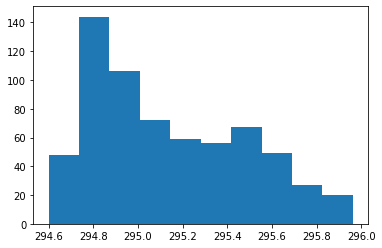

In [23]:
plt.hist(X[0][17:-1])

(array([3., 1., 0., 0., 0., 1., 1., 2., 3., 5.]),
 array([0.7934 , 0.80665, 0.8199 , 0.83315, 0.8464 , 0.85965, 0.8729 ,
        0.88615, 0.8994 , 0.91265, 0.9259 ]),
 <BarContainer object of 10 artists>)

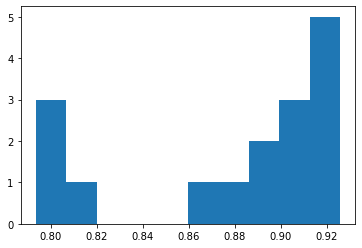

In [22]:
plt.hist(X[0][0:16])

In [33]:
def create_preproc(X):
    scaler = StandardScaler()

    return scaler


## Preproc data

Just to show the preproc model ⬇️

In [34]:
preproc = create_preproc(X)

Fit and transform the data ⬇️

In [35]:
preproc.fit(X)

StandardScaler()

# Machine Learning

In [42]:
pipe_baseline = make_pipeline(preproc, Ridge())
pipe_baseline

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [43]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
score_baseline

-86.64324113965301

In [ ]:
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

# Deep Learning

## Preproc data

In [44]:
X_preproc = preproc.transform(X)

## Create validation split

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_preproc, y, test_size=0.3, random_state=0)

## Initialize model

See the shape of your data and try insert the number of columns in the input_dim value

In [55]:
X_train.shape

(24084, 666)

In [56]:
input_dim = 666 #insert here the number of dimensions of the X data

In [127]:
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.01

lr = ExponentialDecay(
    initial_learning_rate, decay_steps=500, decay_rate=0.7,
)

def initialize_model(input_dim, lr):

    
    model = models.Sequential()

    opt = Adam(learning_rate=lr)
    
    model.add(layers.Dense(20, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear')) 

    model.compile(optimizer=opt,
                  loss='msle',
                  metrics='mae')# optimize for the squared log error!
    
    return model

Initialize modal and show its summary

In [130]:
model = initialize_model(input_dim, lr=0.001)
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 20)                13340     
_________________________________________________________________
dense_73 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_74 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 21        
Total params: 14,201
Trainable params: 14,201
Non-trainable params: 0
_________________________________________________________________


## Fit model to your data

In [131]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=100,
                    batch_size=32, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/100
527/527 [==============================] - 1s 2ms/step - loss: 0.8415 - mae: 6.7852 - val_loss: 0.5021 - val_mae: 5.8338
Epoch 2/100
527/527 [==============================] - 1s 2ms/step - loss: 0.5000 - mae: 5.8176 - val_loss: 0.4407 - val_mae: 5.5180
Epoch 3/100
527/527 [==============================] - 1s 2ms/step - loss: 0.4530 - mae: 5.5578 - val_loss: 0.3767 - val_mae: 5.3073
Epoch 4/100
527/527 [==============================] - 1s 2ms/step - loss: 0.4091 - mae: 5.3613 - val_loss: 0.3523 - val_mae: 5.1331
Epoch 5/100
527/527 [==============================] - 1s 2ms/step - loss: 0.3970 - mae: 5.2872 - val_loss: 0.3262 - val_mae: 4.9788
Epoch 6/100
527/527 [==============================] - 1s 2ms/step - loss: 0.3570 - mae: 5.1386 - val_loss: 0.3277 - val_mae: 5.1217
Epoch 7/100
527/527 [==============================] - 1s 2ms/step - loss: 0.3670 - mae: 5.1288 - val_loss: 0.3114 - val_mae: 4.9102
Epoch 8/100
527/527 [==============================] - 1s 2ms/step - 

## Evaluate the model

In [132]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('MSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

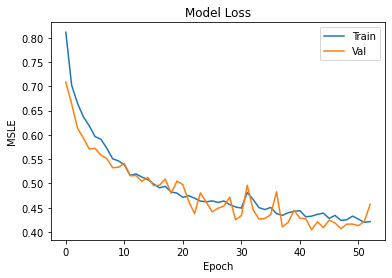

In [133]:
plot_history(history)

In [134]:
model.evaluate(X_val, y_val, verbose=0)

[0.16979514062404633, 3.9955451488494873]

## Predict the data

In [135]:
y_pred = model.predict(preproc.transform(X))

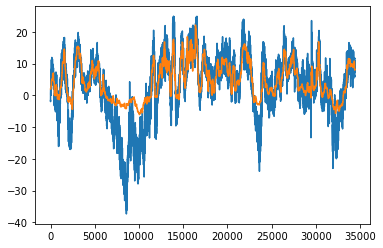

In [136]:
plt.plot(y)
plt.plot(y_pred)